In [9]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import nn, optim
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from tqdm import tqdm
import math

import sys
sys.path.append('/repo')

device = torch.device('cpu')
print('Using device:', device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


Using device: cpu


In [2]:
from src.models.FaceSentiment import ConvNetLarge
model = ConvNetLarge(num_features=5)
model.load_state_dict(torch.load("./exports/trial2/Larger CNN_lr01wdNone.pt", weights_only=True))
model.to(device)

ConvNetLarge(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=36864, out_features=2048, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=2048, out_features=1024, bias=True)
  (dropout4): Dropout(p=0.5, inplace=False)
  (fc3): Linear(in_features=1024, out_features=5, bias=True)
)

In [ ]:
import cv2
import numpy as np
import torchvision.transforms as transforms
from PIL import Image

# Custom transform for histogram equalization
class HistogramEqualization:
    def __call__(self, img):
        # Convert PIL image to numpy array
        img_array = np.array(img)
        
        # Apply histogram equalization
        img_eq = cv2.equalizeHist(img_array)
        
        # Convert back to PIL image
        return Image.fromarray(img_eq)

val_transforms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),
    HistogramEqualization(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize the grayscale image
])

# Load the datasets with ImageFolder
val_dataset = datasets.ImageFolder(root='./FerPlus/fer2013plus/fer2013/train/', transform=val_transforms)


# Create DataLoaders for training and validation
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=4)

class_names = ["Angry", "Happy", "Neutral", "Sad", "Surprised"]


In [47]:
import tqdm as notebook_tqdm
import shap

preprocess = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.Grayscale(),  # Ensure the image is grayscale
    HistogramEqualization(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize the grayscale image
])

# Function to make predictions
def preprocess_image(image):
    image = Image.open(image)
    
    # Preprocess the image
    input_tensor = preprocess(image).unsqueeze(0)  # Add batch dimension
    
    # Move the input to the device (CPU or GPU)
    input_tensor = input_tensor.to(device)
    
    # Make the prediction
    with torch.no_grad():
        output = model(input_tensor)
    
    # If you are using a softmax output, convert to probabilities
    probabilities = F.softmax(output, dim=1)
    
    # Get the predicted class
    predicted_class = class_names[torch.argmax(probabilities, dim=1)[0]]

    probs = list(probabilities.cpu().detach().numpy())[0]
    probs = [int(p * 100) for p in probs]
    
    return input_tensor, predicted_class, probs

# Start explainer

In [15]:
batch = next(iter(val_loader))
images, _ = batch

images = images.view(-1, 1, 48, 48)

e = shap.DeepExplainer(model, images)

# test

prediction: 2 = Neutral


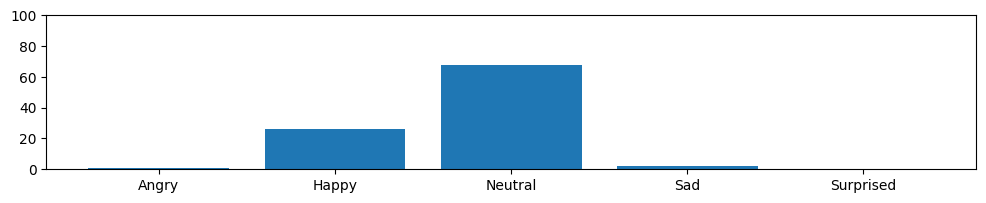

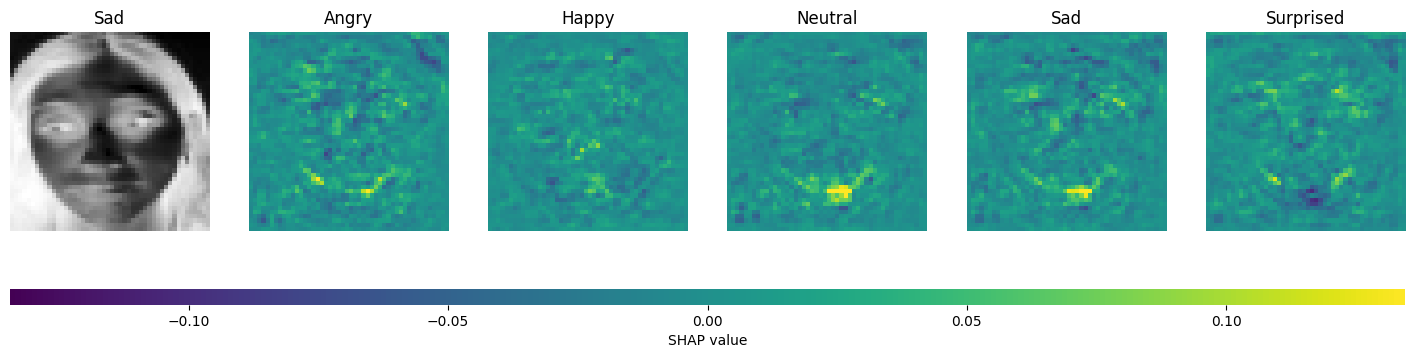

prediction: 2 = Neutral


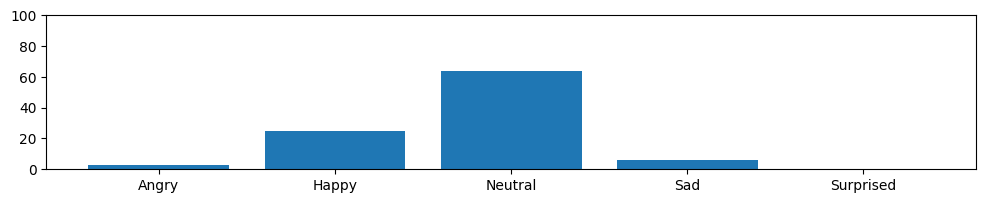

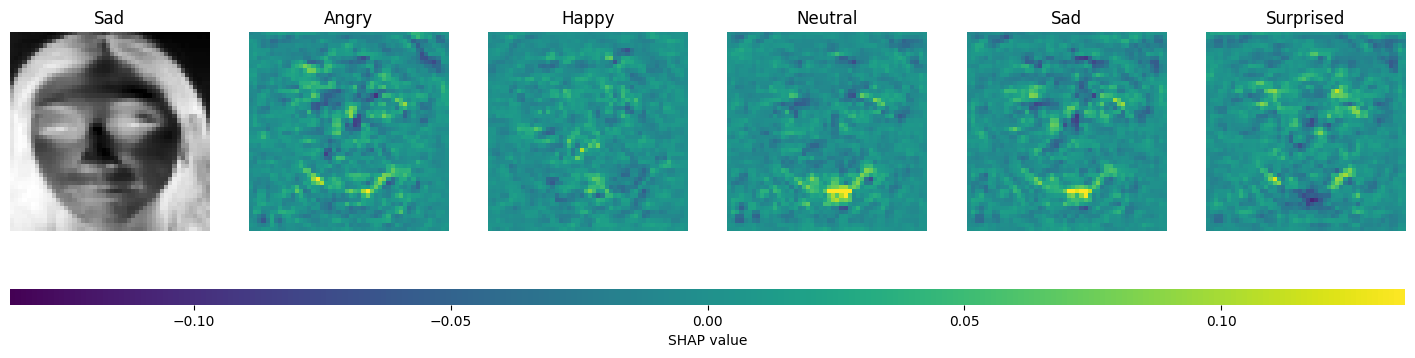

prediction: 0 = Angry


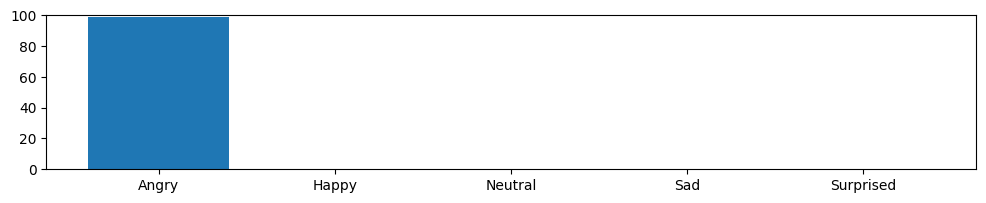

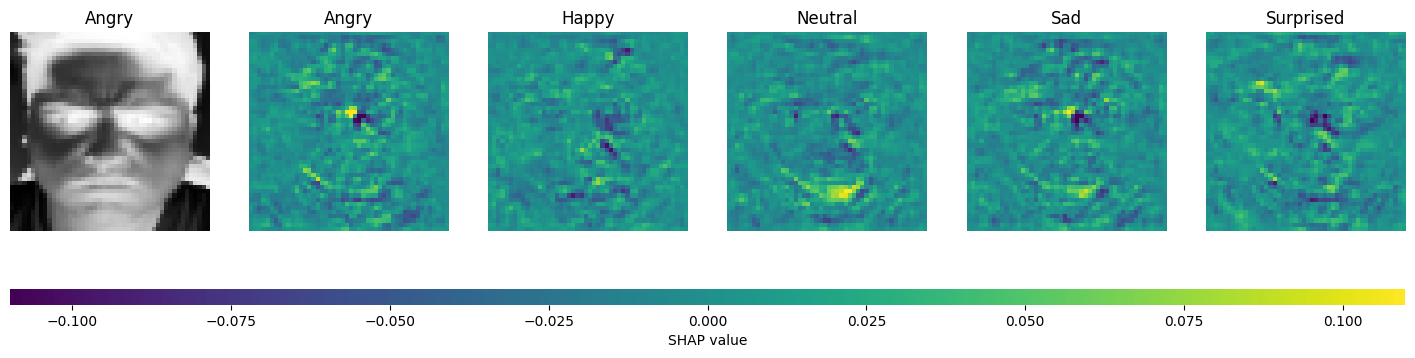

prediction: 1 = Happy


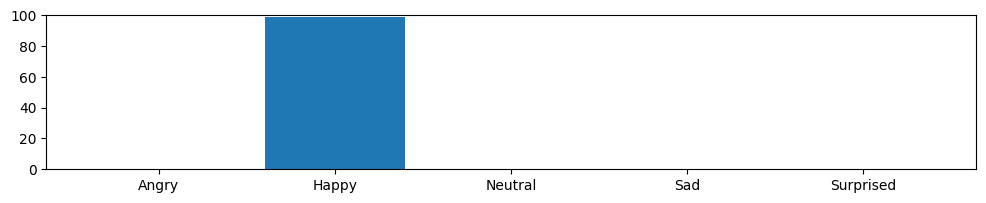

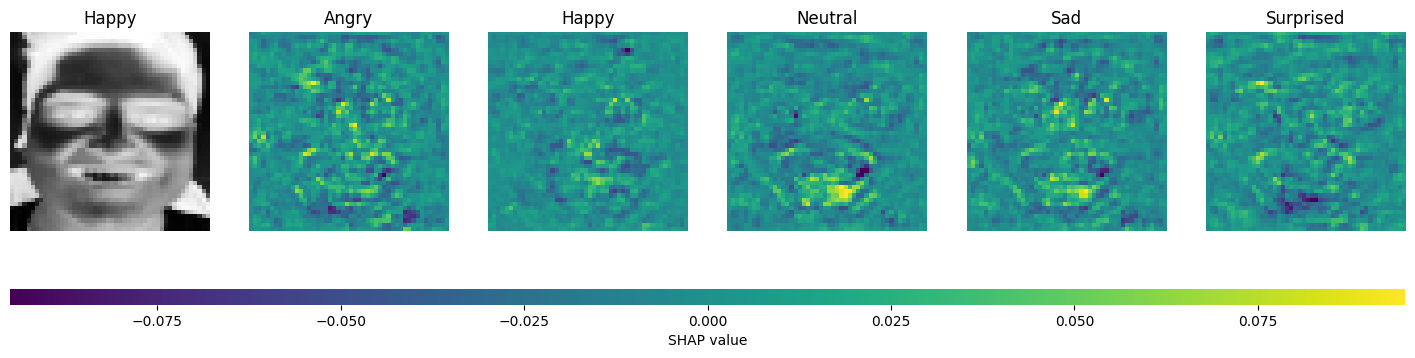

prediction: 2 = Neutral


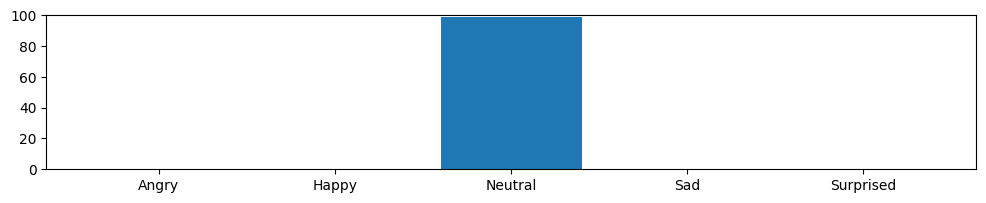

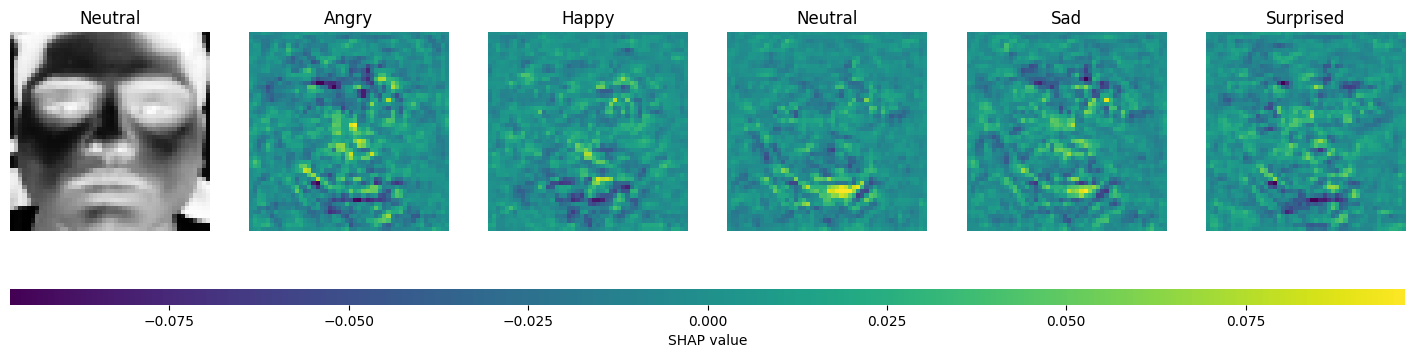

prediction: 2 = Neutral


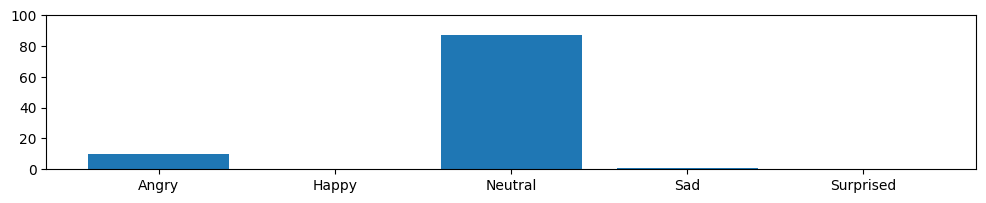

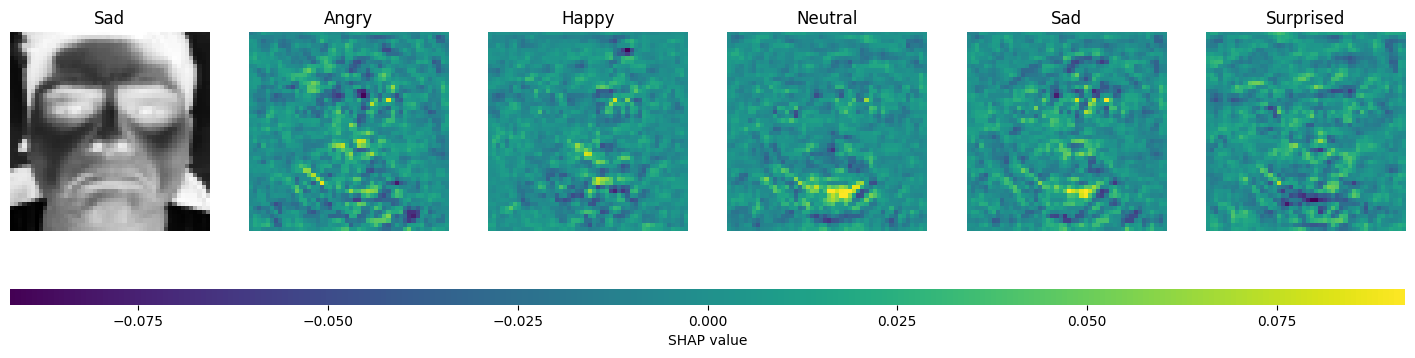

prediction: 4 = Surprised


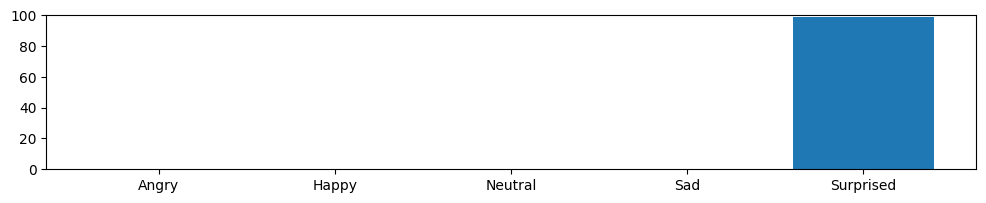

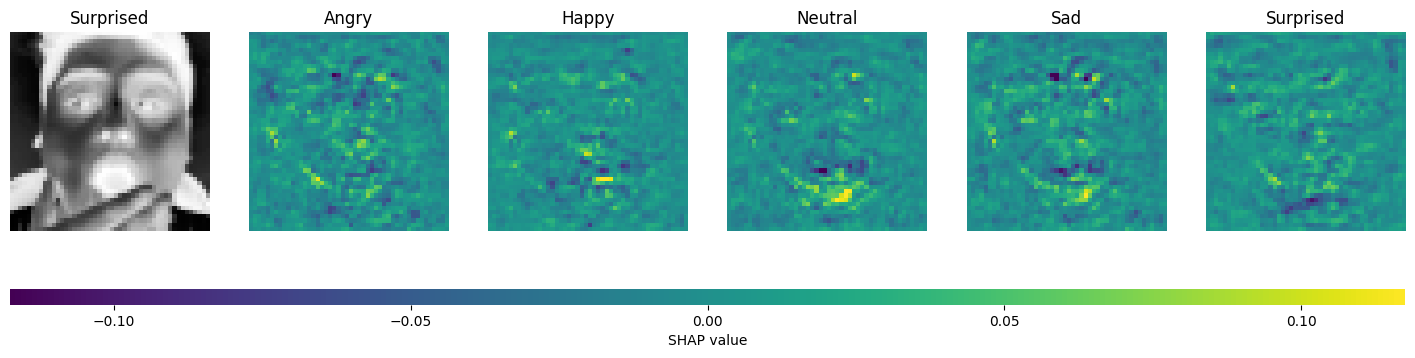

In [49]:


def explain(image_path, true_label=None):
    test, pred, probs = preprocess_image(image_path)
    shap_values = e.shap_values(test, check_additivity=False)

    shap_numpy = list(np.transpose(shap_values, (4, 0, 2, 3, 1)))
    test_numpy = np.swapaxes(np.swapaxes(test.numpy(), 1, -1), 1, 2)

    print("prediction:", class_names.index(pred), "=", pred)

    plt.figure(figsize=(12, 2))
    plt.bar(class_names, probs)
    plt.ylim(0, 100)
    plt.show()
    
    shap.image_plot(
        shap_numpy,
        -test_numpy,
        labels=class_names,
        true_labels=[class_names[true_label]],
        cmap="viridis"
    )

explain('./test/sad1.png', 3)
explain('./test/sad2.png', 3)

explain('./test/angry.png', 0)
explain('./test/happy.png', 1)
explain('./test/neutral.png', 2)
explain('./test/sad.png', 3)
explain('./test/surprise.png', 4)